# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf

In [2]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data

In [3]:
company = '^FCHI' # Symbol of CAC40
#company = 'BTC-USD'

start = dt.datetime(1990,3,1)
#start = dt.datetime(2014, 9, 17)
today = dt.datetime.now()

df = yf.download(company, start = start, end=today)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-03-01,1836.0,1838.0,1827.0,1832.0,1832.0,0
1990-03-02,1831.0,1860.0,1831.0,1860.0,1860.0,0
1990-03-05,1866.0,1874.0,1862.0,1874.0,1874.0,0
1990-03-06,1869.0,1875.0,1866.0,1872.0,1872.0,0
1990-03-07,1874.0,1881.0,1874.0,1880.0,1880.0,0


In [5]:
close_train = df["Close"]["2000-01-03":"2018-12-31"] / 1e6
close_valid = df["Close"]["2019-01-01":"2021-05-31"] / 1e6
close_test = df["Close"]["2021-06-01":] / 1e6

In [6]:
seq_length = 50
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    close_train.to_numpy(),
    targets=close_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    close_valid.to_numpy(),
    targets=close_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

# Linear model

In [28]:
tf.random.set_seed(42)
linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.99)
linear_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = linear_model.fit(train_ds, validation_data=valid_ds, epochs=1000,
                    callbacks=[early_stopping_cb])

Epoch 1/1000
151/151 [==============================] - 4s 13ms/step - loss: 1.5060e-05 - mae: 0.0047 - val_loss: 1.0923e-06 - val_mae: 0.0012
Epoch 2/1000
151/151 [==============================] - 1s 6ms/step - loss: 4.4780e-06 - mae: 0.0024 - val_loss: 9.5223e-07 - val_mae: 0.0012
Epoch 3/1000
151/151 [==============================] - 1s 6ms/step - loss: 2.5070e-06 - mae: 0.0018 - val_loss: 5.1302e-06 - val_mae: 0.0030
Epoch 4/1000
151/151 [==============================] - 1s 6ms/step - loss: 2.1101e-06 - mae: 0.0017 - val_loss: 3.6206e-06 - val_mae: 0.0025
Epoch 5/1000
151/151 [==============================] - 1s 6ms/step - loss: 2.0614e-06 - mae: 0.0017 - val_loss: 3.2274e-06 - val_mae: 0.0023
Epoch 6/1000
151/151 [==============================] - 1s 6ms/step - loss: 2.0379e-06 - mae: 0.0017 - val_loss: 3.5389e-06 - val_mae: 0.0024
Epoch 7/1000
151/151 [==============================] - 1s 6ms/step - loss: 2.0397e-06 - mae: 0.0017 - val_loss: 3.4999e-06 - val_mae: 0.0024
Epoch

In [29]:
# extra code – evaluates the model
valid_loss, valid_mae = linear_model.evaluate(valid_ds)
valid_mae * 1e6

18/18 [==============================] - 0s 5ms/step - loss: 9.5223e-07 - mae: 0.0012


1171.6594453901052

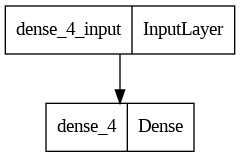

In [30]:
tf.keras.utils.plot_model(
    linear_model,
    to_file='linear_model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

# Simple RNN

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [11]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=1000):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.99)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae","mse"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae,valid_mse = model.evaluate(valid_set)
    return valid_mae * 1e6, valid_mse *1e6

In [12]:
mae_rnn, mse_rnn = fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.152)

Epoch 1/1000
151/151 [==============================] - 4s 20ms/step - loss: 2.8379e-06 - mae: 0.0020 - mse: 5.6758e-06 - val_loss: 2.7304e-06 - val_mae: 0.0022 - val_mse: 5.4608e-06
Epoch 2/1000
151/151 [==============================] - 2s 11ms/step - loss: 6.4029e-07 - mae: 9.2864e-04 - mse: 1.2806e-06 - val_loss: 3.0833e-07 - val_mae: 5.7794e-04 - val_mse: 6.1666e-07
Epoch 3/1000
151/151 [==============================] - 2s 11ms/step - loss: 4.1967e-07 - mae: 7.2745e-04 - mse: 8.3934e-07 - val_loss: 6.9881e-07 - val_mae: 0.0011 - val_mse: 1.3976e-06
Epoch 4/1000
151/151 [==============================] - 2s 12ms/step - loss: 2.3582e-07 - mae: 5.1605e-04 - mse: 4.7163e-07 - val_loss: 4.1917e-07 - val_mae: 7.0833e-04 - val_mse: 8.3833e-07
Epoch 5/1000
151/151 [==============================] - 2s 11ms/step - loss: 2.1915e-07 - mae: 4.9466e-04 - mse: 4.3830e-07 - val_loss: 3.7612e-07 - val_mae: 6.0146e-04 - val_mse: 7.5223e-07
Epoch 6/1000
151/151 [==============================] - 3

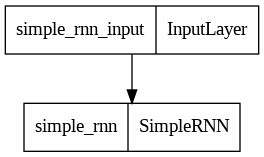

In [13]:
tf.keras.utils.plot_model(
    model,
    to_file='rnn_model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [14]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [15]:
mae_univar, mse_univar = fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.152, epochs=2000)

Epoch 1/2000
151/151 [==============================] - 4s 15ms/step - loss: 4.3534 - mae: 4.7909 - mse: 46.2129 - val_loss: 5.6282 - val_mae: 6.1282 - val_mse: 37.5551
Epoch 2/2000
151/151 [==============================] - 2s 13ms/step - loss: 18.9046 - mae: 19.3974 - mse: 607.5593 - val_loss: 8.4249 - val_mae: 8.9249 - val_mse: 79.6530
Epoch 3/2000
151/151 [==============================] - 2s 12ms/step - loss: 6.8326 - mae: 7.3157 - mse: 111.7859 - val_loss: 1.3093 - val_mae: 1.8093 - val_mse: 3.2734
Epoch 4/2000
151/151 [==============================] - 2s 12ms/step - loss: 4.0536 - mae: 4.5473 - mse: 24.9206 - val_loss: 4.9970 - val_mae: 5.4970 - val_mse: 30.2173
Epoch 5/2000
151/151 [==============================] - 3s 19ms/step - loss: 4.1267 - mae: 4.6267 - mse: 26.9735 - val_loss: 0.5460 - val_mae: 1.0460 - val_mse: 1.0941
Epoch 6/2000
151/151 [==============================] - 2s 13ms/step - loss: 4.1353 - mae: 4.6353 - mse: 24.9996 - val_loss: 1.6523 - val_mae: 2.1523 - v

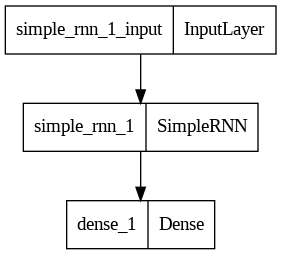

In [16]:
tf.keras.utils.plot_model(
    univar_model,
    to_file='univar_model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

# Deep RNN

In [17]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [18]:
mae_deep, mse_deep = fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.0027)

Epoch 1/1000
151/151 [==============================] - 9s 43ms/step - loss: 0.0056 - mae: 0.0868 - mse: 0.0112 - val_loss: 0.0020 - val_mae: 0.0625 - val_mse: 0.0039
Epoch 2/1000
151/151 [==============================] - 5s 34ms/step - loss: 7.5021e-04 - mae: 0.0341 - mse: 0.0015 - val_loss: 4.8298e-05 - val_mae: 0.0098 - val_mse: 9.6596e-05
Epoch 3/1000
151/151 [==============================] - 5s 30ms/step - loss: 1.4986e-04 - mae: 0.0152 - mse: 2.9971e-04 - val_loss: 9.9592e-05 - val_mae: 0.0141 - val_mse: 1.9918e-04
Epoch 4/1000
151/151 [==============================] - 7s 45ms/step - loss: 3.4195e-05 - mae: 0.0073 - mse: 6.8390e-05 - val_loss: 3.3529e-05 - val_mae: 0.0082 - val_mse: 6.7057e-05
Epoch 5/1000
151/151 [==============================] - 5s 31ms/step - loss: 7.9480e-06 - mae: 0.0035 - mse: 1.5896e-05 - val_loss: 4.0130e-06 - val_mae: 0.0028 - val_mse: 8.0260e-06
Epoch 6/1000
151/151 [==============================] - 5s 29ms/step - loss: 2.1911e-06 - mae: 0.0018 - m

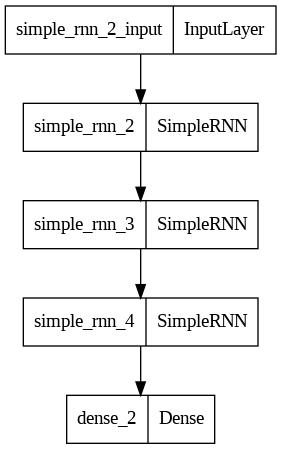

In [19]:
tf.keras.utils.plot_model(
    deep_model,
    to_file='deep_model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

# Multivariate time series

In [20]:
df_mulvar = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_close"] = df["Close"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [21]:
mulvar_train = df_mulvar["1990-03-01":"2018-12-31"]
#mulvar_train = df_mulvar["2014-09-17":"2018-12-31"]
mulvar_valid = df_mulvar["2019-01-01":"2021-05-31"]
mulvar_test = df_mulvar["2021-06-01":]

In [22]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["Close"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["Close"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [23]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 7]),
    tf.keras.layers.Dense(1)
])

In [24]:
mae_mul, mse_mul = fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.102)

Epoch 1/1000
227/227 [==============================] - 5s 14ms/step - loss: 0.0986 - mae: 0.3811 - mse: 0.1972 - val_loss: 0.0028 - val_mae: 0.0743 - val_mse: 0.0055
Epoch 2/1000
227/227 [==============================] - 3s 13ms/step - loss: 0.0101 - mae: 0.1213 - mse: 0.0201 - val_loss: 0.0047 - val_mae: 0.0965 - val_mse: 0.0093
Epoch 3/1000
227/227 [==============================] - 3s 12ms/step - loss: 0.0010 - mae: 0.0393 - mse: 0.0020 - val_loss: 2.7922e-04 - val_mae: 0.0236 - val_mse: 5.5844e-04
Epoch 4/1000
227/227 [==============================] - 4s 18ms/step - loss: 1.8230e-04 - mae: 0.0170 - mse: 3.6461e-04 - val_loss: 2.6515e-05 - val_mae: 0.0073 - val_mse: 5.3030e-05
Epoch 5/1000
227/227 [==============================] - 3s 13ms/step - loss: 4.6881e-05 - mae: 0.0085 - mse: 9.3762e-05 - val_loss: 6.6325e-05 - val_mae: 0.0115 - val_mse: 1.3265e-04
Epoch 6/1000
227/227 [==============================] - 3s 13ms/step - loss: 3.0131e-05 - mae: 0.0068 - mse: 6.0262e-05 - val

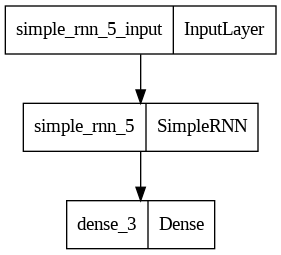

In [25]:
tf.keras.utils.plot_model(
    mulvar_model,
    to_file='mulvar_model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

# Forecasting Several Steps Ahead

In [26]:
import numpy as np

X = close_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 25ms/step


In [28]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [29]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 7]),
    tf.keras.layers.Dense(14)
])

In [30]:
mae_ahead, mse_ahead = fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.152)

Epoch 1/1000
227/227 [==============================] - 10s 39ms/step - loss: 0.1149 - mae: 0.3246 - mse: 0.2524 - val_loss: 0.0498 - val_mae: 0.2370 - val_mse: 0.0996
Epoch 2/1000
227/227 [==============================] - 7s 29ms/step - loss: 0.0117 - mae: 0.1011 - mse: 0.0235 - val_loss: 0.0049 - val_mae: 0.0737 - val_mse: 0.0098
Epoch 3/1000
227/227 [==============================] - 8s 37ms/step - loss: 0.0012 - mae: 0.0325 - mse: 0.0024 - val_loss: 4.7110e-04 - val_mae: 0.0225 - val_mse: 9.4220e-04
Epoch 4/1000
227/227 [==============================] - 8s 35ms/step - loss: 1.2327e-04 - mae: 0.0105 - mse: 2.4653e-04 - val_loss: 4.9173e-05 - val_mae: 0.0070 - val_mse: 9.8345e-05
Epoch 5/1000
227/227 [==============================] - 7s 30ms/step - loss: 1.4078e-05 - mae: 0.0037 - mse: 2.8157e-05 - val_loss: 5.2541e-06 - val_mae: 0.0023 - val_mse: 1.0508e-05
Epoch 6/1000
227/227 [==============================] - 7s 30ms/step - loss: 2.6651e-06 - mae: 0.0018 - mse: 5.3301e-06 - va

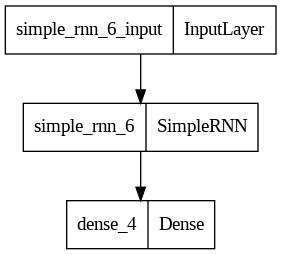

In [31]:
tf.keras.utils.plot_model(
    ahead_model,
    to_file='ahead_model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [67]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 7]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

print(Y_pred * 1e6)

1/1 [==============================] - 0s 31ms/step
[[5468.799  5462.6167 5511.742  5466.07   5418.5625 5454.229  5431.045
  5386.792  5421.906  5513.4165 5578.202  5611.9663 5596.146  5658.8574]]


# Deep RNNs with Layer Norm

In [33]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [34]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [35]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [36]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [37]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 7]),
    tf.keras.layers.Dense(14)
])

In [38]:
mae_cstm, mse_cstm = fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.162, epochs=10000)

Epoch 1/10000
227/227 [==============================] - 27s 111ms/step - loss: 0.0259 - mae: 0.1629 - mse: 0.0519 - val_loss: 0.0045 - val_mae: 0.0769 - val_mse: 0.0091
Epoch 2/10000
227/227 [==============================] - 24s 107ms/step - loss: 0.0016 - mae: 0.0430 - mse: 0.0032 - val_loss: 5.7244e-04 - val_mae: 0.0289 - val_mse: 0.0011
Epoch 3/10000
227/227 [==============================] - 25s 112ms/step - loss: 1.5090e-04 - mae: 0.0133 - mse: 3.0181e-04 - val_loss: 3.8261e-05 - val_mae: 0.0072 - val_mse: 7.6522e-05
Epoch 4/10000
227/227 [==============================] - 25s 110ms/step - loss: 1.7080e-05 - mae: 0.0045 - mse: 3.4159e-05 - val_loss: 3.2570e-06 - val_mae: 0.0019 - val_mse: 6.5139e-06
Epoch 5/10000
227/227 [==============================] - 25s 109ms/step - loss: 3.7223e-06 - mae: 0.0022 - mse: 7.4445e-06 - val_loss: 1.7479e-06 - val_mae: 0.0015 - val_mse: 3.4958e-06
Epoch 6/10000
227/227 [==============================] - 23s 101ms/step - loss: 1.8238e-06 - mae: 

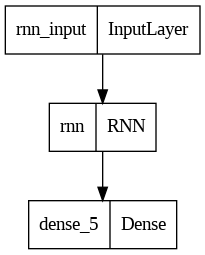

In [39]:
tf.keras.utils.plot_model(
    custom_ln_model,
    to_file='custom_ln_model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

# LSTM

In [40]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 7]),
    tf.keras.layers.Dense(14)
])

In [41]:
mae_lstm, mse_lstm = fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.16)

Epoch 1/1000
227/227 [==============================] - 6s 16ms/step - loss: 0.0392 - mae: 0.1923 - mse: 0.0784 - val_loss: 0.0170 - val_mae: 0.1473 - val_mse: 0.0341
Epoch 2/1000
227/227 [==============================] - 5s 21ms/step - loss: 0.0040 - mae: 0.0618 - mse: 0.0081 - val_loss: 5.5643e-04 - val_mae: 0.0268 - val_mse: 0.0011
Epoch 3/1000
227/227 [==============================] - 3s 13ms/step - loss: 4.1997e-04 - mae: 0.0199 - mse: 8.3993e-04 - val_loss: 8.8376e-06 - val_mae: 0.0026 - val_mse: 1.7675e-05
Epoch 4/1000
227/227 [==============================] - 3s 14ms/step - loss: 4.5593e-05 - mae: 0.0067 - mse: 9.1186e-05 - val_loss: 1.2451e-05 - val_mae: 0.0035 - val_mse: 2.4902e-05
Epoch 5/1000
227/227 [==============================] - 3s 14ms/step - loss: 7.5281e-06 - mae: 0.0028 - mse: 1.5056e-05 - val_loss: 3.2222e-06 - val_mae: 0.0019 - val_mse: 6.4444e-06
Epoch 6/1000
227/227 [==============================] - 3s 14ms/step - loss: 3.6986e-06 - mae: 0.0022 - mse: 7.39

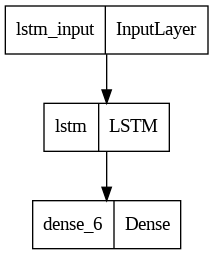

In [42]:
tf.keras.utils.plot_model(
    lstm_model,
    to_file='lstm_model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

# GRU

In [43]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 7]),
    tf.keras.layers.Dense(14)
])

In [44]:
mae_gru, mse_gru = fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.3)

Epoch 1/1000
227/227 [==============================] - 5s 15ms/step - loss: 0.0578 - mae: 0.2339 - mse: 0.1168 - val_loss: 0.0101 - val_mae: 0.1140 - val_mse: 0.0202
Epoch 2/1000
227/227 [==============================] - 4s 16ms/step - loss: 0.0057 - mae: 0.0730 - mse: 0.0113 - val_loss: 0.0014 - val_mae: 0.0280 - val_mse: 0.0028
Epoch 3/1000
227/227 [==============================] - 3s 13ms/step - loss: 5.7259e-04 - mae: 0.0231 - mse: 0.0011 - val_loss: 2.0205e-04 - val_mae: 0.0161 - val_mse: 4.0410e-04
Epoch 4/1000
227/227 [==============================] - 3s 15ms/step - loss: 6.0747e-05 - mae: 0.0076 - mse: 1.2149e-04 - val_loss: 1.0297e-05 - val_mae: 0.0038 - val_mse: 2.0594e-05
Epoch 5/1000
227/227 [==============================] - 4s 19ms/step - loss: 9.5534e-06 - mae: 0.0033 - mse: 1.9107e-05 - val_loss: 1.8938e-06 - val_mae: 0.0012 - val_mse: 3.7876e-06
Epoch 6/1000
227/227 [==============================] - 3s 13ms/step - loss: 2.1865e-06 - mae: 0.0017 - mse: 4.3731e-06 -

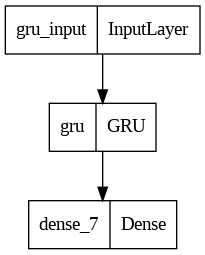

In [45]:
tf.keras.utils.plot_model(
    gru_model,
    to_file='gru_model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

# Using One-Dimensional Convolutional Layers to Process Sequences

In [46]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 7]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [47]:
mae_conv, mse_conv = fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.185)

Epoch 1/1000
225/225 [==============================] - 10s 18ms/step - loss: 0.0744 - mae: 0.2789 - mse: 0.1505 - val_loss: 0.0172 - val_mae: 0.1469 - val_mse: 0.0344
Epoch 2/1000
225/225 [==============================] - 4s 18ms/step - loss: 0.0076 - mae: 0.0896 - mse: 0.0153 - val_loss: 0.0012 - val_mae: 0.0334 - val_mse: 0.0024
Epoch 3/1000
225/225 [==============================] - 4s 18ms/step - loss: 7.7735e-04 - mae: 0.0286 - mse: 0.0016 - val_loss: 1.8243e-04 - val_mae: 0.0148 - val_mse: 3.6487e-04
Epoch 4/1000
225/225 [==============================] - 4s 16ms/step - loss: 8.9493e-05 - mae: 0.0097 - mse: 1.7899e-04 - val_loss: 3.6574e-05 - val_mae: 0.0067 - val_mse: 7.3148e-05
Epoch 5/1000
225/225 [==============================] - 6s 24ms/step - loss: 8.5996e-06 - mae: 0.0031 - mse: 1.7199e-05 - val_loss: 3.2409e-06 - val_mae: 0.0020 - val_mse: 6.4818e-06
Epoch 6/1000
225/225 [==============================] - 4s 16ms/step - loss: 1.9479e-06 - mae: 0.0016 - mse: 3.8958e-06 

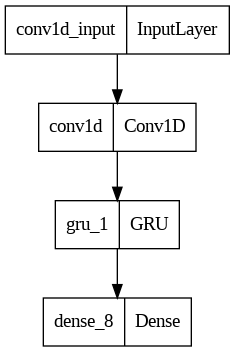

In [48]:
tf.keras.utils.plot_model(
    conv_rnn_model,
    to_file='conv_rnn_model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [49]:
print(mae_conv)
print(mse_conv)

931.1721660196781
1.0750096635092632


# WaveNet

In [50]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [51]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [52]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 3  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 7])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

In [53]:
mae_wave, mse_wave = fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.4)

Epoch 1/1000
225/225 [==============================] - 9s 28ms/step - loss: 1.9698e-04 - mae: 0.0129 - mse: 3.9395e-04 - val_loss: 9.3502e-06 - val_mae: 0.0035 - val_mse: 1.8700e-05
Epoch 2/1000
225/225 [==============================] - 8s 36ms/step - loss: 1.6773e-05 - mae: 0.0042 - mse: 3.3545e-05 - val_loss: 4.3620e-06 - val_mae: 0.0024 - val_mse: 8.7239e-06
Epoch 3/1000
225/225 [==============================] - 5s 21ms/step - loss: 3.4217e-06 - mae: 0.0019 - mse: 6.8435e-06 - val_loss: 9.6531e-07 - val_mae: 0.0011 - val_mse: 1.9306e-06
Epoch 4/1000
225/225 [==============================] - 5s 21ms/step - loss: 1.7797e-06 - mae: 0.0014 - mse: 3.5594e-06 - val_loss: 2.2954e-07 - val_mae: 5.3867e-04 - val_mse: 4.5909e-07
Epoch 5/1000
225/225 [==============================] - 4s 16ms/step - loss: 1.5651e-06 - mae: 0.0014 - mse: 3.1301e-06 - val_loss: 2.2763e-07 - val_mae: 5.2501e-04 - val_mse: 4.5526e-07
Epoch 6/1000
225/225 [==============================] - 4s 19ms/step - loss: 

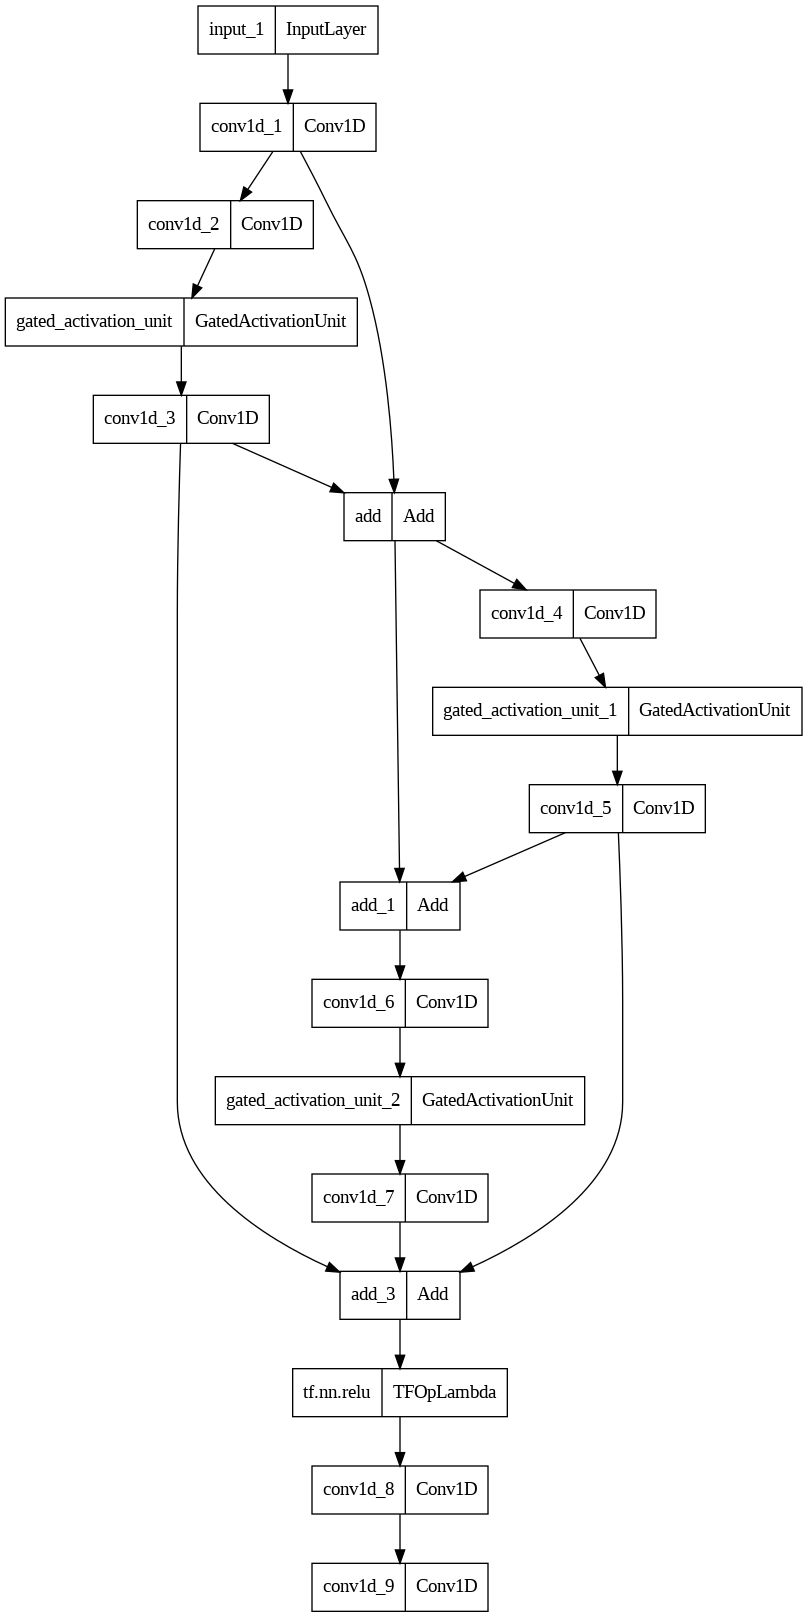

In [54]:
tf.keras.utils.plot_model(
    full_wavenet_model,
    to_file='full_wavenet_model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

# GRU - Custom

In [55]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
yt_model1 = tf.keras.Sequential([
    tf.keras.layers.GRU(200, return_sequences=True, input_shape=[None, 7]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(200, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(200, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(14)
])

In [56]:
mae_yt1, mse_yt1 = fit_and_evaluate(yt_model1, seq2seq_train, seq2seq_valid,
                 learning_rate=0.3)

Epoch 1/1000
227/227 [==============================] - 11s 22ms/step - loss: 0.1891 - mae: 0.3691 - mse: 0.5570 - val_loss: 0.0014 - val_mae: 0.0393 - val_mse: 0.0029
Epoch 2/1000
227/227 [==============================] - 5s 20ms/step - loss: 0.0015 - mae: 0.0396 - mse: 0.0030 - val_loss: 4.8659e-04 - val_mae: 0.0245 - val_mse: 9.7317e-04
Epoch 3/1000
227/227 [==============================] - 5s 20ms/step - loss: 1.6472e-04 - mae: 0.0135 - mse: 3.2944e-04 - val_loss: 1.7161e-05 - val_mae: 0.0044 - val_mse: 3.4323e-05
Epoch 4/1000
227/227 [==============================] - 4s 18ms/step - loss: 1.9702e-05 - mae: 0.0049 - mse: 3.9405e-05 - val_loss: 5.5259e-06 - val_mae: 0.0026 - val_mse: 1.1052e-05
Epoch 5/1000
227/227 [==============================] - 5s 22ms/step - loss: 5.1570e-06 - mae: 0.0025 - mse: 1.0314e-05 - val_loss: 9.0106e-07 - val_mae: 0.0011 - val_mse: 1.8021e-06
Epoch 6/1000
227/227 [==============================] - 5s 20ms/step - loss: 3.8876e-06 - mae: 0.0024 - mse:

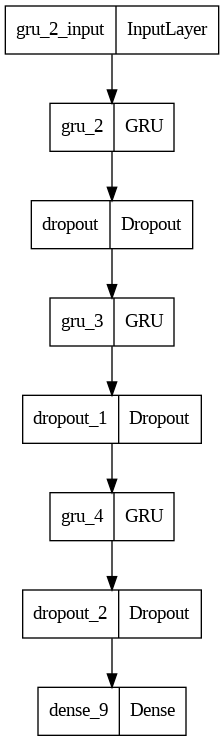

In [57]:
tf.keras.utils.plot_model(
    yt_model1,
    to_file='yt_model1.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [58]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
yt_model2 = tf.keras.Sequential([

    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2, activation="relu", input_shape=[None, 7]),
    tf.keras.layers.GRU(32, return_sequences=True),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
])

In [59]:
mae_yt2, mse_yt2 = fit_and_evaluate(yt_model2, downsampled_train, downsampled_valid,
                 learning_rate=0.25)

Epoch 1/1000
225/225 [==============================] - 7s 21ms/step - loss: 0.0722 - mae: 0.2936 - mse: 0.1460 - val_loss: 0.0296 - val_mae: 0.2170 - val_mse: 0.0593
Epoch 2/1000
225/225 [==============================] - 5s 23ms/step - loss: 0.0074 - mae: 0.0943 - mse: 0.0148 - val_loss: 0.0031 - val_mae: 0.0719 - val_mse: 0.0062
Epoch 3/1000
225/225 [==============================] - 4s 16ms/step - loss: 7.5123e-04 - mae: 0.0298 - mse: 0.0015 - val_loss: 2.9319e-04 - val_mae: 0.0223 - val_mse: 5.8638e-04
Epoch 4/1000
225/225 [==============================] - 6s 24ms/step - loss: 7.2370e-05 - mae: 0.0090 - mse: 1.4474e-04 - val_loss: 2.3402e-05 - val_mae: 0.0061 - val_mse: 4.6805e-05
Epoch 5/1000
225/225 [==============================] - 4s 16ms/step - loss: 7.2155e-06 - mae: 0.0027 - mse: 1.4431e-05 - val_loss: 2.1871e-06 - val_mae: 0.0018 - val_mse: 4.3741e-06
Epoch 6/1000
225/225 [==============================] - 4s 15ms/step - loss: 1.6563e-06 - mae: 0.0013 - mse: 3.3125e-06 -

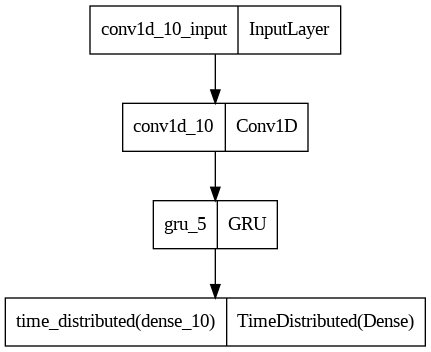

In [60]:
tf.keras.utils.plot_model(
    yt_model2,
    to_file='yt_model2.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
yt_model3 = tf.keras.Sequential([

    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2, activation="relu", input_shape=[None, 7]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
])

In [ ]:
mae_yt3, mse_yt3 = fit_and_evaluate(yt_model3, downsampled_train, downsampled_valid,
                 learning_rate=0.1)

In [ ]:
tf.keras.utils.plot_model(
    yt_model3,
    to_file='yt_model3.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

# Graphs

## 1 Step Ahead

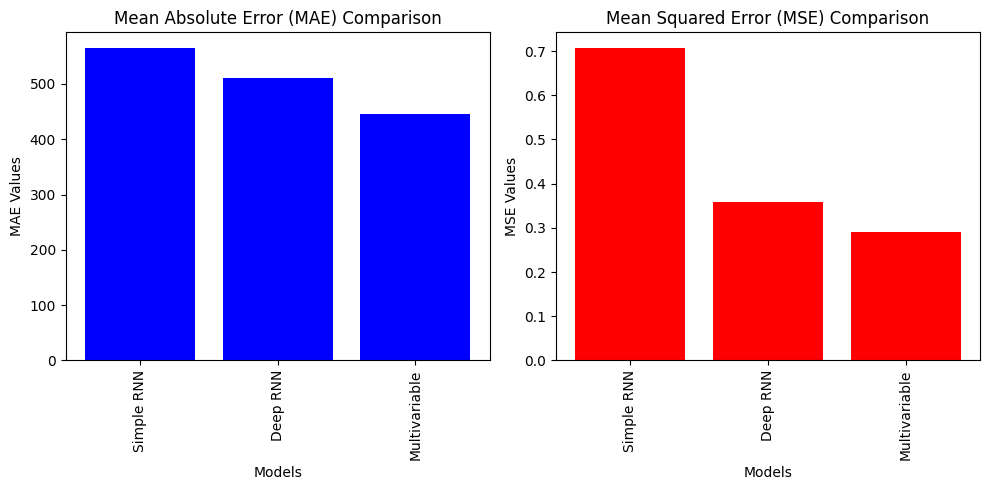

In [34]:
model_data = {
    #'Linear Model': {'MAE': valid_mae*1e6, 'MSE': 0.0},
    'Simple RNN': {'MAE': mae_rnn, 'MSE': mse_rnn},
    #'Univariable': {'MAE': mae_univar, 'MSE': mse_univar},
    'Deep RNN': {'MAE': mae_deep, 'MSE': mse_deep},
    'Multivariable': {'MAE': mae_mul, 'MSE': mse_mul}
}

# Extracting model names, MAE values, and MSE values from the dictionary
models = list(model_data.keys())
mae_values = [model_data[model]['MAE'] for model in models]
mse_values = [model_data[model]['MSE'] for model in models]

# Creating bar charts to compare MAE values of different models
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(models, mae_values, color='blue')
plt.title('Mean Absolute Error (MAE) Comparison')
plt.xlabel('Models')
plt.ylabel('MAE Values')
plt.xticks(rotation='vertical')

# Creating bar charts to compare MSE values of different models
plt.subplot(1, 2, 2)
plt.bar(models, mse_values, color='red')
plt.title('Mean Squared Error (MSE) Comparison')
plt.xlabel('Models')
plt.ylabel('MSE Values')
plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

## 14 Step Ahead

In [35]:
model_data = {
    '14 Step Ahead': {'MAE': mae_ahead, 'MSE': mse_ahead},
    'Custom LN': {'MAE': mae_cstm, 'MSE': mse_cstm},
    'LSTM': {'MAE': mae_lstm, 'MSE': mse_lstm},
    'GRU': {'MAE': mae_gru, 'MSE': mse_gru},
    '1-Dim Conv Layer': {'MAE': mae_conv, 'MSE': mse_conv},
    'Wavenet': {'MAE': mae_wave, 'MSE': mse_wave},
    'GRU - v2': {'MAE': mae_yt1, 'MSE': mse_yt1},
    '1-Dim Conv Layer - v2': {'MAE': mae_yt2, 'MSE': mse_yt2},
    '1-Dim Conv Layer - v3': {'MAE': mae_yt3, 'MSE': mse_yt3}
}

# Extracting model names, MAE values, and MSE values from the dictionary
models = list(model_data.keys())
mae_values = [model_data[model]['MAE'] for model in models]
mse_values = [model_data[model]['MSE'] for model in models]

# Creating bar charts to compare MAE values of different models
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(models, mae_values, color='blue')
plt.title('Mean Absolute Error (MAE) Comparison')
plt.xlabel('Models')
plt.ylabel('MAE Values')
plt.xticks(rotation='vertical')

# Creating bar charts to compare MSE values of different models
plt.subplot(1, 2, 2)
plt.bar(models, mse_values, color='red')
plt.title('Mean Squared Error (MSE) Comparison')
plt.xlabel('Models')
plt.ylabel('MSE Values')
plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

NameError: ignored